In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [22]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=500, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanSquaredError("auto", "mean_squared_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [23]:
#Training data set
folder = 'Darcy'

input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

INPUTDIM = (input_train.shape[1],input_train.shape[2])
OUTPUTDIM = (output_train.shape[1],output_train.shape[2])

(16, 9)


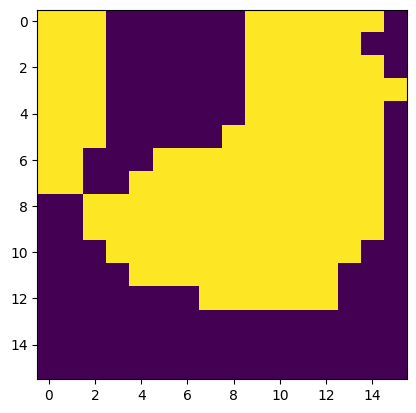

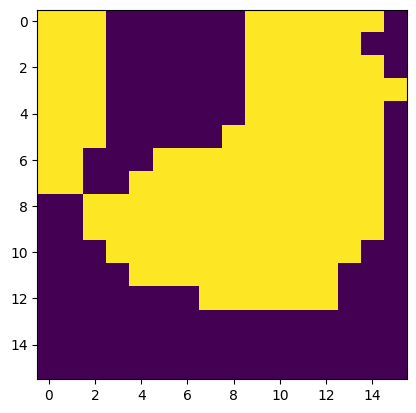

In [24]:
k_max = 9
test = input_train[0]
plt.figure()
plt.imshow(test)
fft = tf.signal.rfft2d(test)
print(fft.shape)
fft = fft[..., :k_max]
ifft = tf.signal.irfft2d(fft)
plt.figure()
plt.imshow(ifft)

In [25]:
class FFT_Layer_2D(tf.keras.layers.Layer):
    def __init__(self, k_max=None, **kwargs):
        super(FFT_Layer_2D, self).__init__(**kwargs)
        self._fft_shape = None
        self._ifft_shape = None
        self.k_max = k_max

    def build(self, input_shape):
        if self.k_max == None:
            self._fft_shape = tf.convert_to_tensor(input_shape[-1] // 2 + 1, dtype=tf.int32)
            self._ifft_shape = tf.multiply(tf.convert_to_tensor(input_shape[-1] // 2, dtype=tf.int32), 2)
        else:
            self._fft_shape = tf.convert_to_tensor(self.k_max, dtype=tf.int32)
            self._ifft_shape = tf.multiply(tf.convert_to_tensor(self.k_max-1, dtype=tf.int32), 2)
        print('fft_shape set:', self._fft_shape.numpy())
        print('ifft_shape set:', self._ifft_shape.numpy())

        self.kernel = self.add_weight(
            name="kernel",
            shape=(self._fft_shape, self._fft_shape),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        fft = tf.signal.rfft2d(inputs)
        if not(self.k_max==None):
            fft = fft[..., :self.k_max]
        kernel_complex = tf.complex(self.kernel, tf.zeros_like(self.kernel))
        r = tf.linalg.matmul(fft, kernel_complex)
        ifft = tf.signal.irfft2d(r)
        return ifft

    @property
    def fft_shape(self):
        return self._fft_shape

    @property
    def ifft_shape(self):
        return self._ifft_shape

    # @fft_shape.setter
    # def fft_shape(self, value):
    #     self._fft_shape = tf.convert_to_tensor(value, dtype=tf.int32)
    #     print('New fft_shape set:', self._fft_shape.numpy())

    # @ifft_shape.setter
    # def ifft_shape(self, value):
    #     self._ifft_shape = tf.convert_to_tensor(value, dtype=tf.int32)
    #     print('New ifft_shape set:', self._ifft_shape.numpy())

class Bias_Layer_2D(tf.keras.layers.Layer):
    def __init__(self, fft_layer_object, **kwargs):
        super(Bias_Layer_2D, self).__init__(**kwargs)
        self.fft_layer_object = fft_layer_object

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.fft_layer_object.ifft_shape),
            initializer="glorot_uniform",
            trainable=True
        )
        print('Bias layer has shape: '+str(self.fft_layer_object.ifft_shape.numpy()))

    def call(self, inputs):
        bias = tf.linalg.matmul(inputs, self.kernel)
        return bias

class Fourier_Layer_2D(tf.keras.layers.Layer):
    
    def __init__(self, k_max=None, **kwargs):
        super(Fourier_Layer_2D, self).__init__(**kwargs)
        self.fft_layer = FFT_Layer_2D(k_max=k_max)
        self.bias_layer = Bias_Layer_2D(self.fft_layer)

    def call(self, inputs):
        fft_layer = self.fft_layer(inputs)
        bias_layer = self.bias_layer(inputs)
        added_layers = layers.Add() ([fft_layer, bias_layer])
        return layers.Activation('relu') (added_layers)
    

n=6
k_max = 9
p_dim = 16

input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

input_layer_flat = layers.Reshape((INPUTDIM[0]*INPUTDIM[1],)) (input_layer)

P_layer = layers.Dense(p_dim**2, activation='relu', kernel_regularizer = regularizers.l2(0.2), name='P_layer') (input_layer_flat)

P_dropout = layers.Dropout(0.2) (P_layer)

P_layer = layers.Reshape((p_dim, p_dim)) (P_dropout)

# Repeat the custom module 'n' times
for i in range(n):
    print('Creating Fourier Layer ' +str(i))
    if i ==0:
        fourier_module_output = Fourier_Layer_2D(name='fourier_layer_'+str(i), k_max=k_max)(P_layer)
    else:
        fourier_module_output = Fourier_Layer_2D(name='fourier_layer_'+str(i), k_max=k_max)(fourier_module_output)

fourier_module_output = layers.Reshape((p_dim*2*(k_max-1),)) (fourier_module_output)

output_layer_flat = layers.Dense(OUTPUTDIM[0]*OUTPUTDIM[1], activation='linear', kernel_regularizer = regularizers.l2(0.2), name='output_layer') (fourier_module_output)

output_dropout = layers.Dropout(0.2) (output_layer_flat)

output_layer = layers.Reshape(OUTPUTDIM) (output_dropout)

print('-------------------------------------------------------')

model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name ='FNO')

model.summary()


Creating Fourier Layer 0
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 1
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 2
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 3
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 4
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 5
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
-------------------------------------------------------
Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16, 16)]          0         
                                                                 
 reshape_8 (Reshape)         (None, 256)               0         
                                                                 
 P_layer (Dense)   

In [26]:
history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, optimizer=None, max_epochs=10000)

Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16, 16)]          0         
                                                                 
 reshape_8 (Reshape)         (None, 256)               0         
                                                                 


 P_layer (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 reshape_9 (Reshape)         (None, 16, 16)            0         
                                                                 
 fourier_layer_0 (Fourier_La  (None, 16, 16)           337       
 yer_2D)                                                         
                                                                 
 fourier_layer_1 (Fourier_La  (None, 16, 16)           337       
 yer_2D)                                                         
                                                                 
 fourier_layer_2 (Fourier_La  (None, 16, 16)           337       
 yer_2D)                                                         
                                                                 
 fourier_l

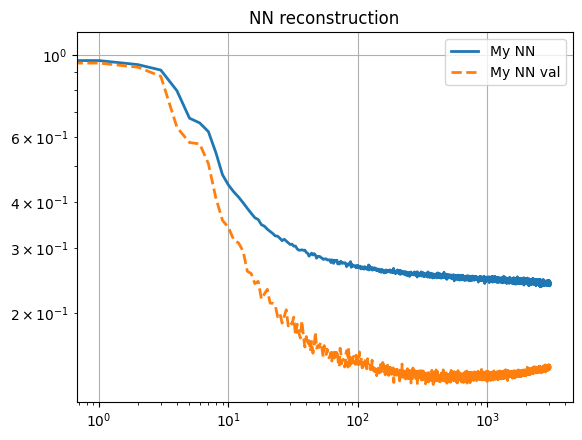

In [27]:
bc     = history.history['mean_squared_error']
val_bc = history.history['val_mean_squared_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)

plt.legend(('My NN','My NN val'))
plt.show()

25/25 [==============================] - 1s 11ms/step


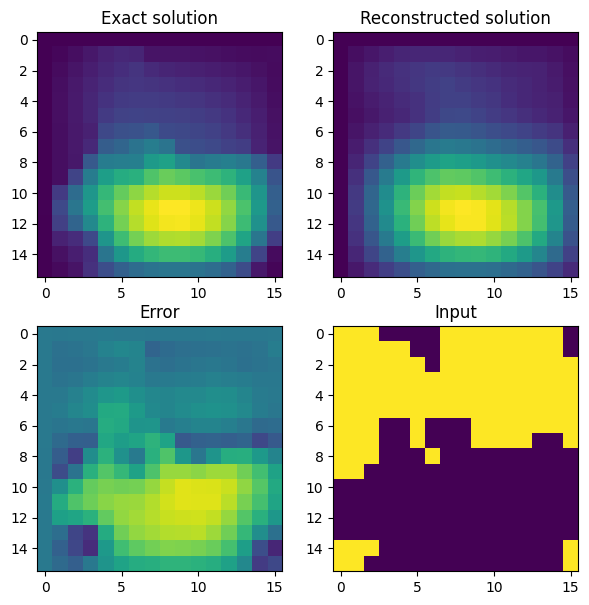

In [28]:
rec_output = model.predict(input_train)
index = 70

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Exact solution')
ax.imshow(output_train[index])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Reconstructed solution')
ax.imshow(rec_output[index])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Error')
ax.imshow(output_train[index]-rec_output[index], vmin=-1, vmax=1)
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Input')
ax.imshow(input_train[index])


7/7 [==============================] - 1s 9ms/step


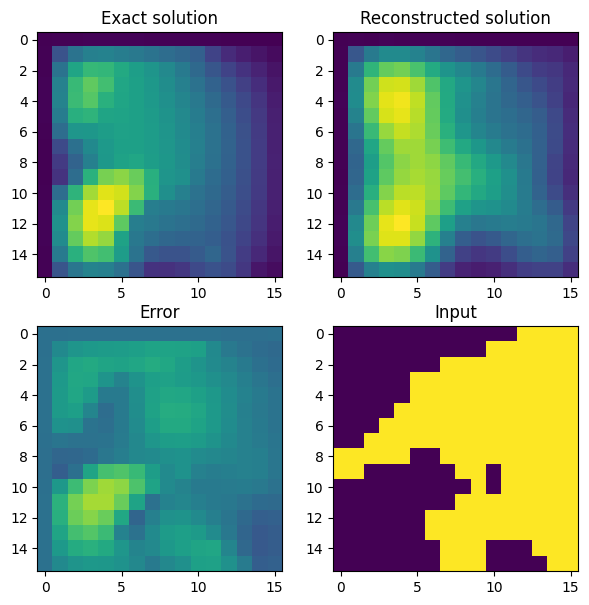

In [29]:
rec_output = model.predict(input_test)
index = 14

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Exact solution')
ax.imshow(output_test[index])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Reconstructed solution')
ax.imshow(rec_output[index])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Error')
ax.imshow(output_test[index]-rec_output[index], vmin=-1, vmax=1)
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Input')
ax.imshow(input_test[index])


In [30]:
save_NN = False
save_NN = True
if save_NN:
    model.save('../data/'+folder+'/model_NN.h5')
    print('NN saved in '+str(folder))

NN saved in Darcy
